In [1]:
import pandas as pd
%pylab inline
%load_ext autoreload
%autoreload 2
#%matplotlib nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

from UKMovementSensing import hsmm

In [33]:
datadir = "/media/sf_VBox_Shared/London/accelerometer_5second/merged/"
path_to_file5sec = os.path.join(datadir, "__016563_2014-08-08 12-02-19.bin_day1.csv")

In [53]:
filenames = os.listdir(datadir)
filenames = [fn for fn in filenames if os.path.isfile(os.path.join(datadir,fn))]
datasets = [pd.read_csv(os.path.join(datadir,fn)) for fn in filenames]
print(len(datasets))

21


In [54]:
for i in range(len(datasets)):
    datasets[i] = datasets[i].set_index('timestamp')
    datasets[i].index = pd.to_datetime(datasets[i].index) 
    datasets[i]['Activity'] = [str(a) for a in datasets[i]['Activity']]
    datasets[i]['filename'] = filenames[i] #TODO weghalen voor nieuwe data

In [55]:
subsets = []
for j, dataset in enumerate(datasets):
    invalids = [1] + list(dataset['invalid']) + [1]
    starts = [i for i in range(1, len(invalids)-1) if invalids[i-1] == 1 and invalids[i] == 0]
    ends = [i for i in range(1, len(invalids)) if invalids[i-1] == 0 and invalids[i] == 1]
    dataset['subset'] = -1
    for i, (s, e) in enumerate(zip(starts, ends)):
        #Some minimum length
        if e-s > 300:
            dataset.loc[s:e, 'subset'] = i
            subsets.append(dataset[s:e].copy())
print(len(subsets))
datasets = subsets

23


In [56]:
example_index = 2
day1_5sec = datasets[example_index]

print(min(day1_5sec.index))
print(max(day1_5sec.index))

2014-08-02 04:00:05
2014-08-03 03:00:00


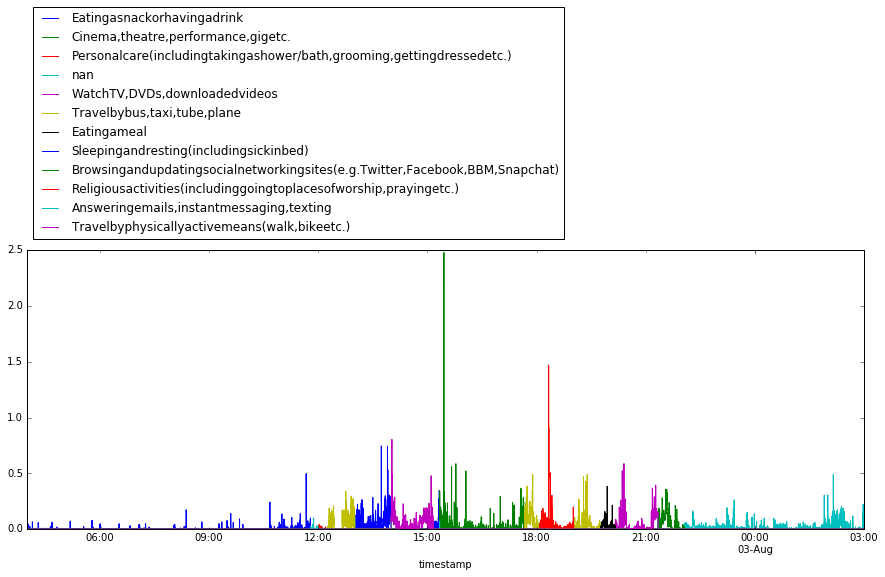

In [38]:
#byAct = day1_5sec.groupby('Activity')
activities = set(day1_5sec['Activity'])
fig, ax = plt.subplots(figsize=(15,5))
for act in activities:
    dfa = day1_5sec.copy()
    dfa[dfa['Activity']!=act] = 0
    dfa['acceleration'].plot(label=act)
legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3);

In [39]:
X_list = [np.column_stack([d.anglex, d.angley, d.anglez, d.acceleration]) for d in datasets] #, day1_5sec.acceleration])
column_names = ['anglex', 'angley', 'anglez', 'acceleration']
print(column_names)

['anglex', 'angley', 'anglez', 'acceleration']


In [40]:
X = X_list[example_index]
print(X.shape)

(16560, 4)


## Create and train the model

In [12]:
Nmax = 4
dim = X.shape[1]

/home/dafne/anaconda2/envs/ucl2/lib/python2.7/site-packages/pybasicbayes/util/stats.py:185: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  x = np.random.randn(nu,n)


0
Resampled 23 sequences in 51.8 seconds
('Log likelihood: ', -4487809.7922028517)
1
Resampled 23 sequences in 48.7 seconds
('Log likelihood: ', -4265240.2430449305)
2
Resampled 23 sequences in 48.3 seconds
('Log likelihood: ', -4165907.0868029143)
3
Resampled 23 sequences in 42.3 seconds
('Log likelihood: ', -4130912.354695336)
4
Resampled 23 sequences in 41.4 seconds
('Log likelihood: ', -4111675.4591516014)
5
Resampled 23 sequences in 41.2 seconds
('Log likelihood: ', -4092826.9314997913)
6
Resampled 23 sequences in 40.8 seconds
('Log likelihood: ', -4075048.8234930276)
7
Resampled 23 sequences in 40.9 seconds
('Log likelihood: ', -4060427.5835851878)
8
Resampled 23 sequences in 40.6 seconds
('Log likelihood: ', -4047668.8893003566)
9
Resampled 23 sequences in 40.4 seconds
('Log likelihood: ', -4034725.3546684152)
10
Resampled 23 sequences in 40.3 seconds
('Log likelihood: ', -4023684.3035260877)
11
Resampled 23 sequences in 40.6 seconds
('Log likelihood: ', -4012781.8135476001)
12


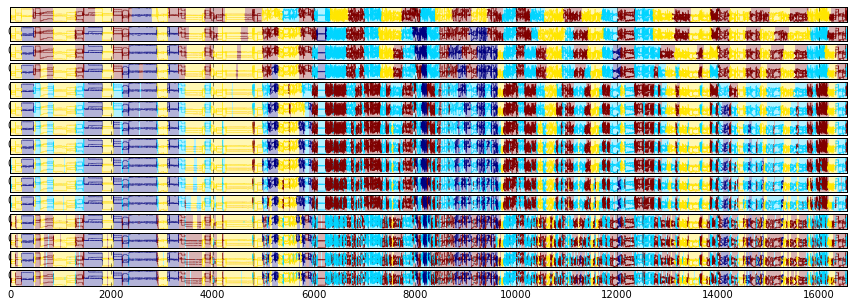

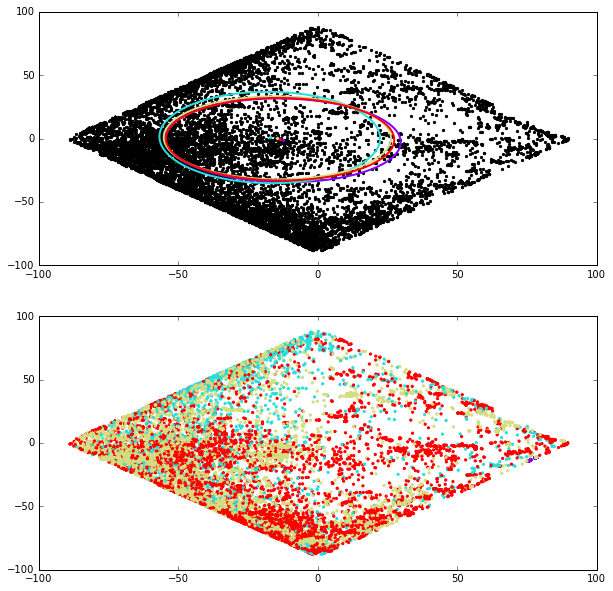

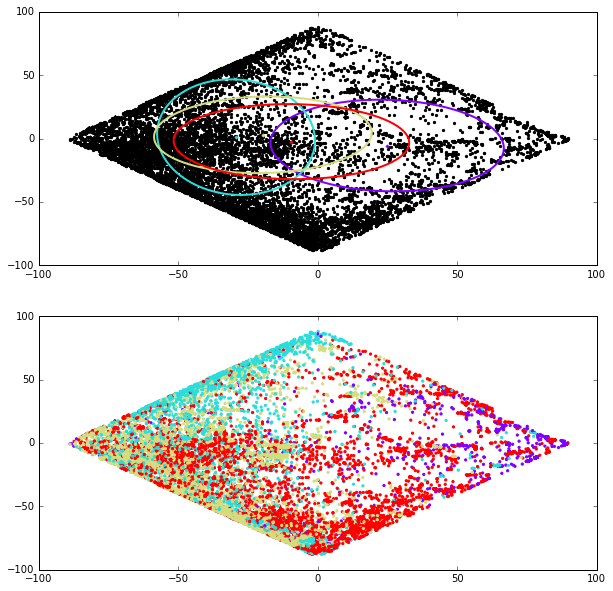

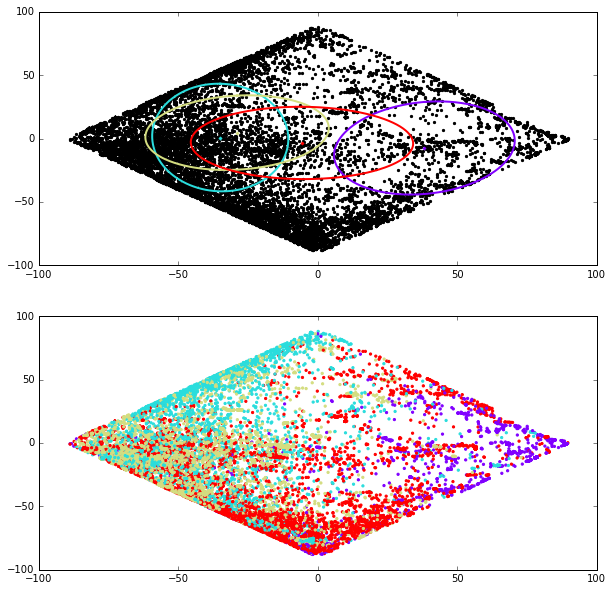

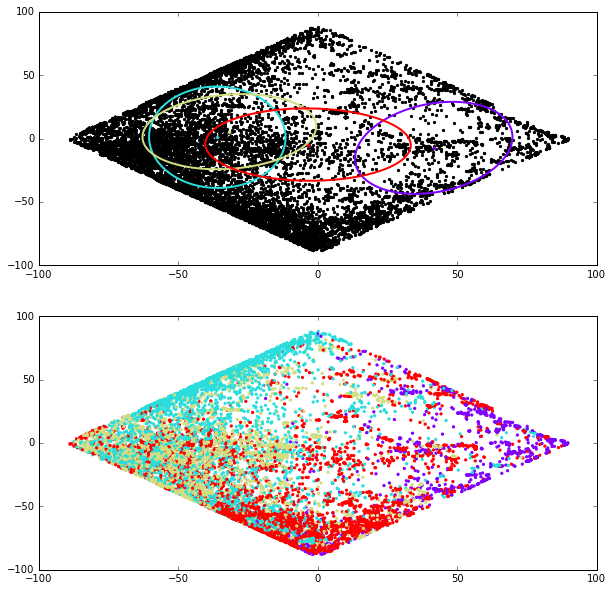

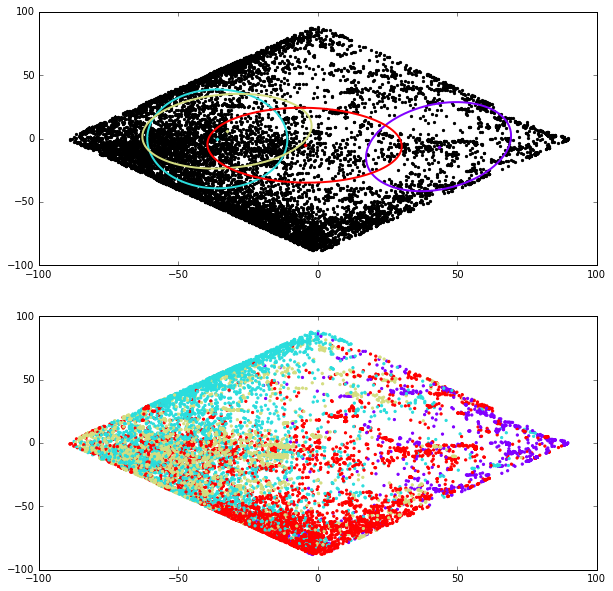

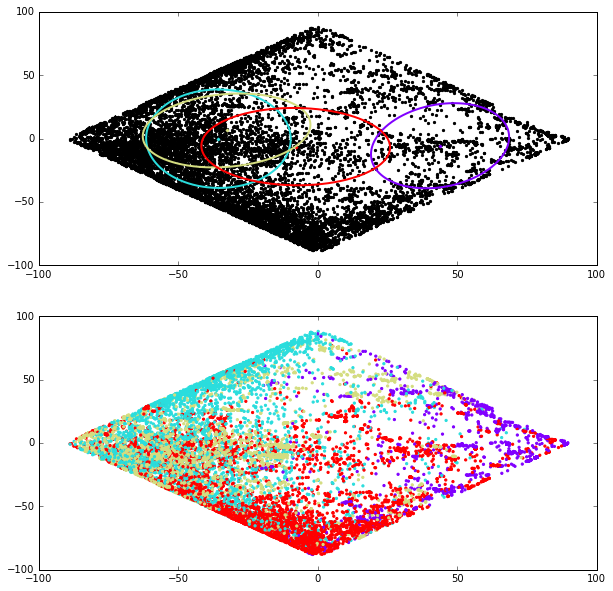

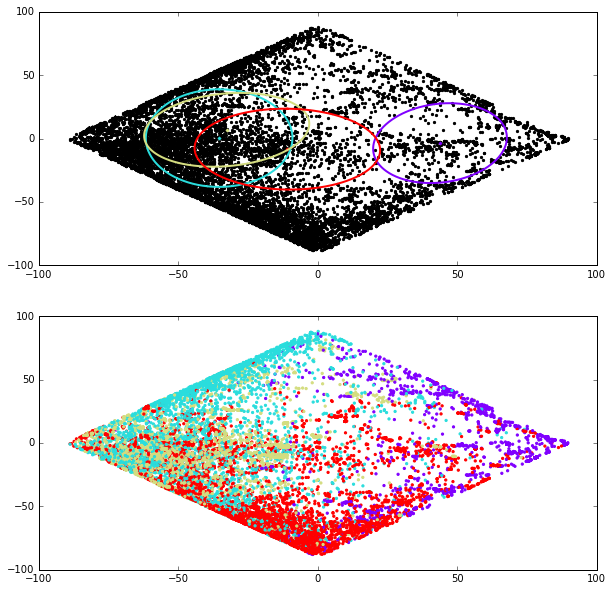

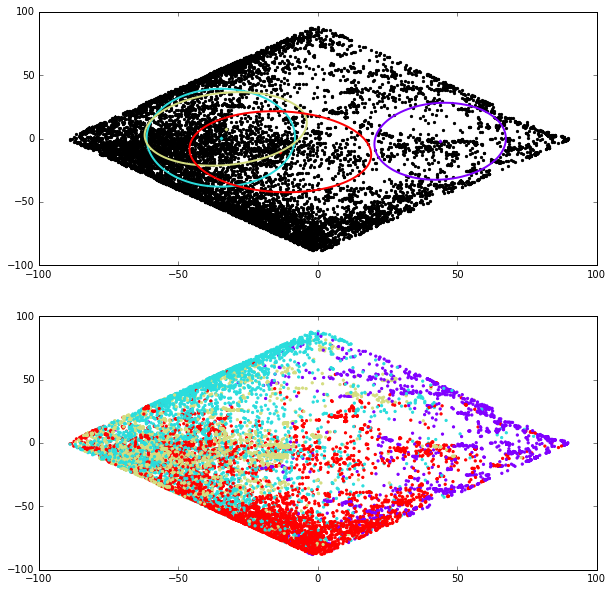

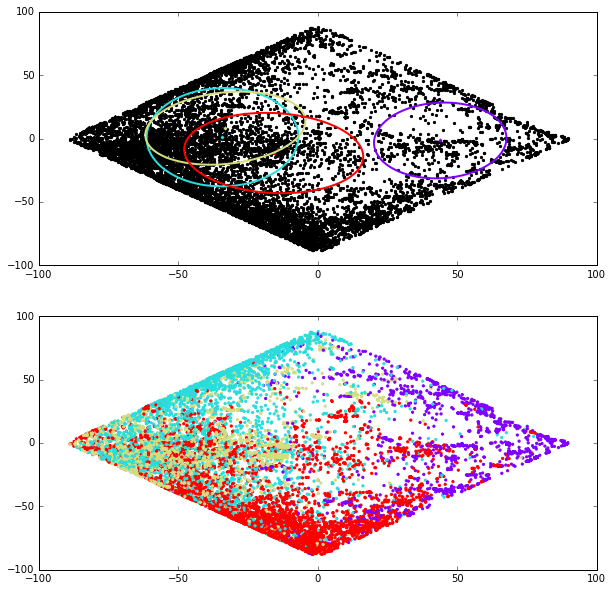

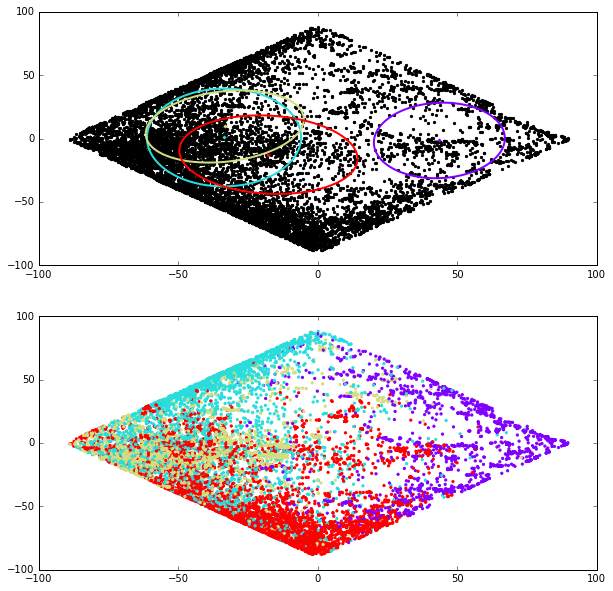

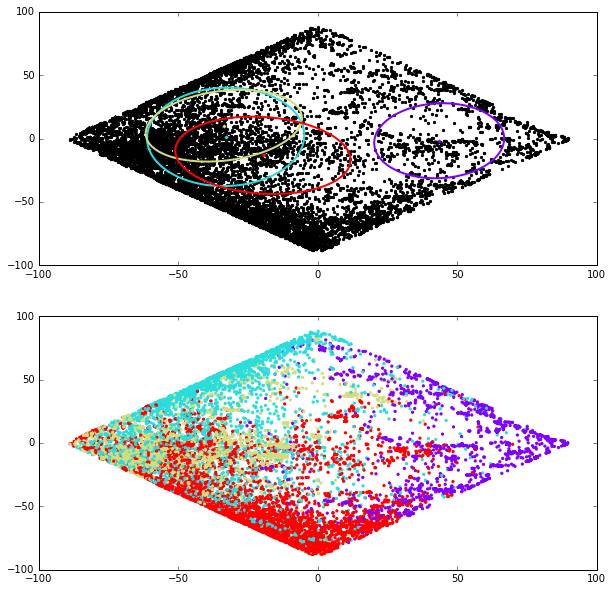

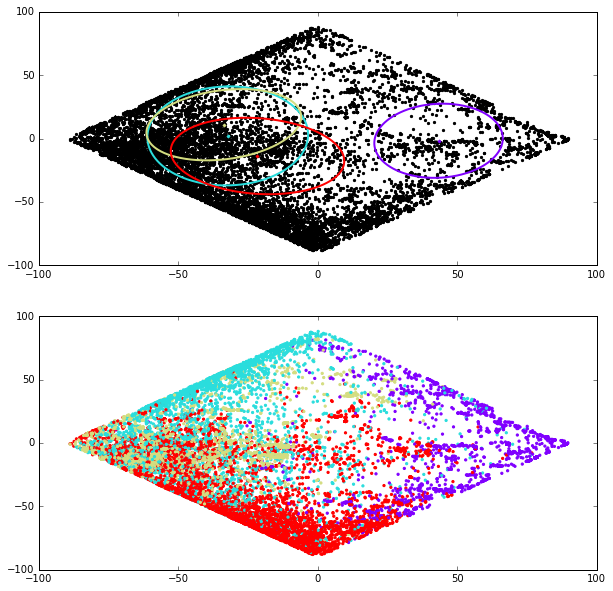

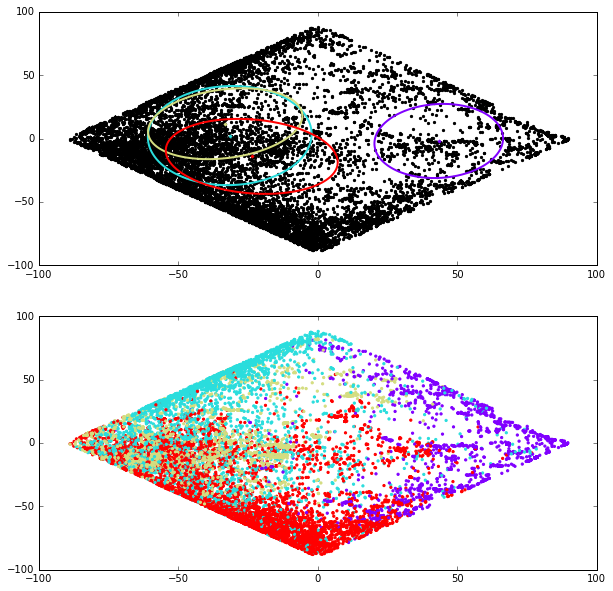

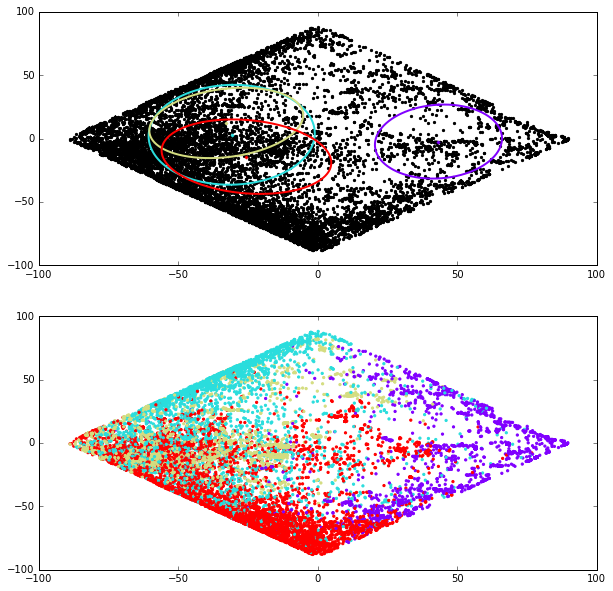

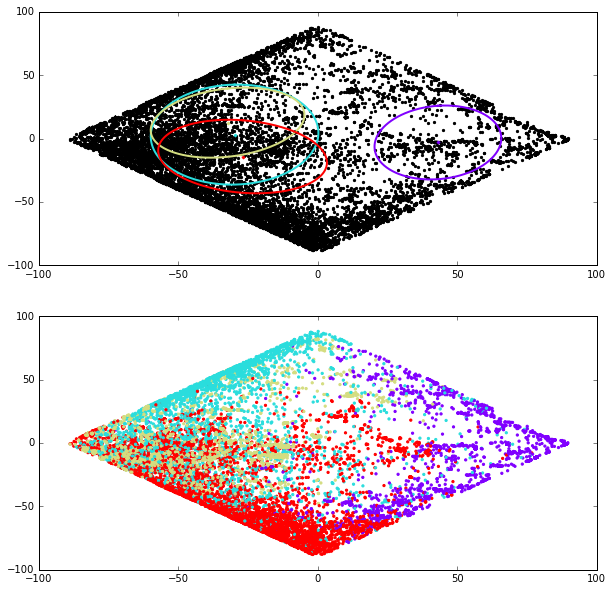

In [13]:
model, model_dist = hsmm.train_hsmm(X_list, Nmax=Nmax, nr_resamples=15, trunc=600, visualize=True, example_index=example_index)

In [15]:
d_old = model_dist[0]
for j, d in enumerate(model_dist):
    #print d[0].mu
    diff = np.array([np.sqrt(np.sum(np.square(d[i].mu - d_old[i].mu))) for i in range(len(d))])
    print(j, np.mean(diff))
    d_old = d

(0, 0.0)
(1, 17.362432285665246)
(2, 11.264940711718175)
(3, 4.3953272626835105)
(4, 2.9657327473834139)
(5, 2.4144768069862703)
(6, 2.1705535157361937)
(7, 1.7252223247103839)
(8, 1.3065938759123226)
(9, 1.2424792417920063)
(10, 0.99273885630721381)
(11, 1.1366139871791119)
(12, 1.1826182298264887)
(13, 1.1339357069337836)
(14, 1.1035473102295248)


In [16]:
import pickle
#TODO: the model object also contains the data so this is not very efficient
with open(os.path.join(datadir, 'models/model_{}states.pkl'.format(Nmax)), 'wb') as f:
    pickle.dump(model, file=f)

In [13]:
import pickle
with open(os.path.join(datadir, 'models/model_{}states.pkl'.format(Nmax)), 'r') as f:
    model = pickle.load(file=f)

In [49]:
data = day1_5sec
hidden_states = model.stateseqs[example_index]

In [57]:
#Save the data with the states
for i, dat in enumerate(datasets):
    dat['state'] = model.stateseqs[i]
    fn = str(str(dat['subset'][0]) + dat['filename'][0])
    dat.to_csv(os.path.join(datadir,'datawithstates/'+fn))

In [19]:
colormap, cmap = hsmm.get_color_map(Nmax)

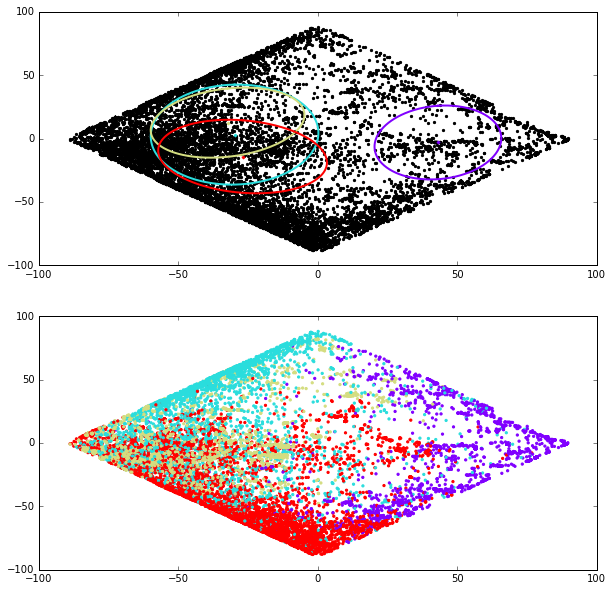

In [20]:
hsmm.plot_observations(X, 0, 1, model, hidden_states, Nmax)

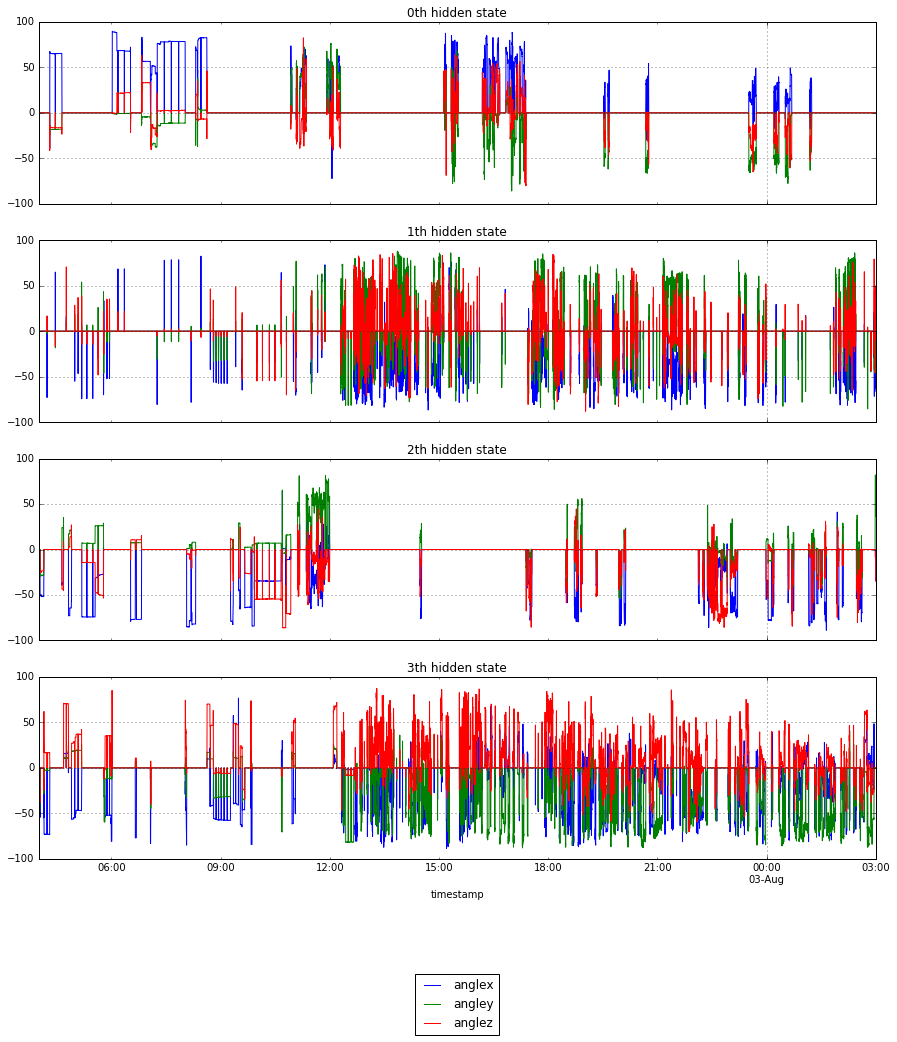

In [21]:
hsmm.plot_perstate(data[['anglex', 'angley', 'anglez']], hidden_states)

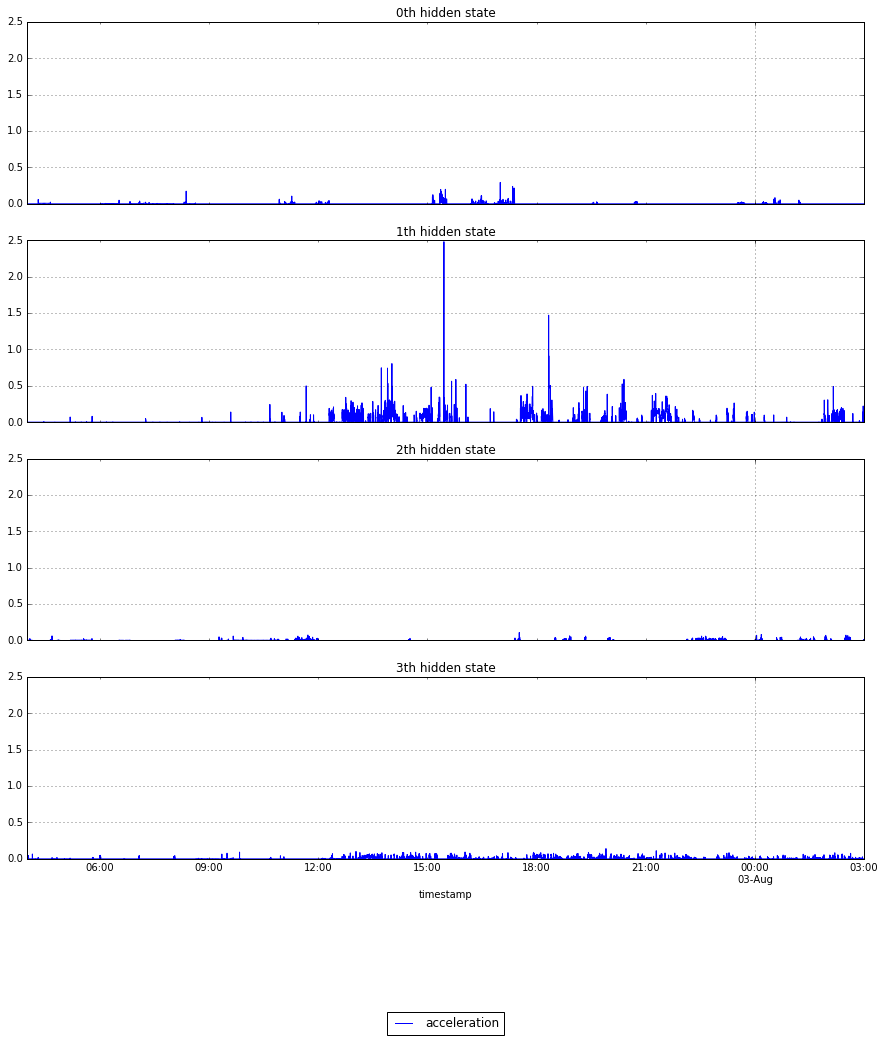

In [22]:
hsmm.plot_perstate(data[['acceleration']], hidden_states)

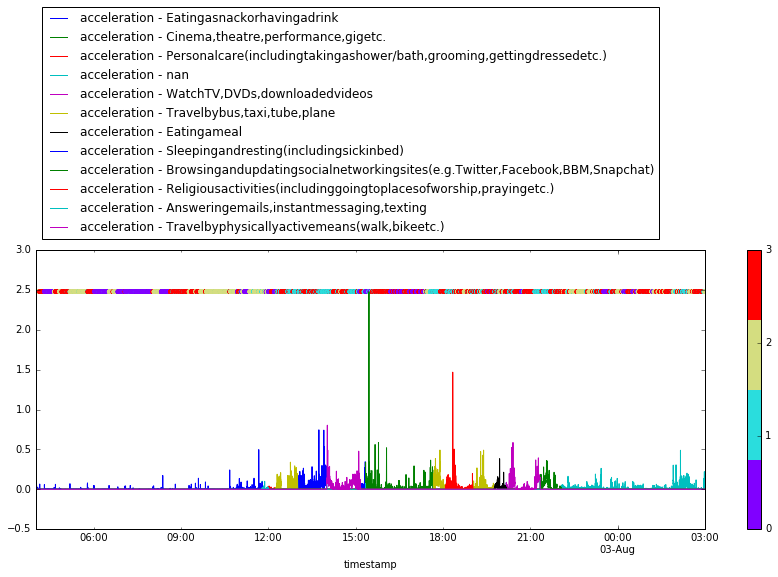

In [23]:
hsmm.plot_states_and_var(data, hidden_states, columns=['acceleration'], by='Activity')

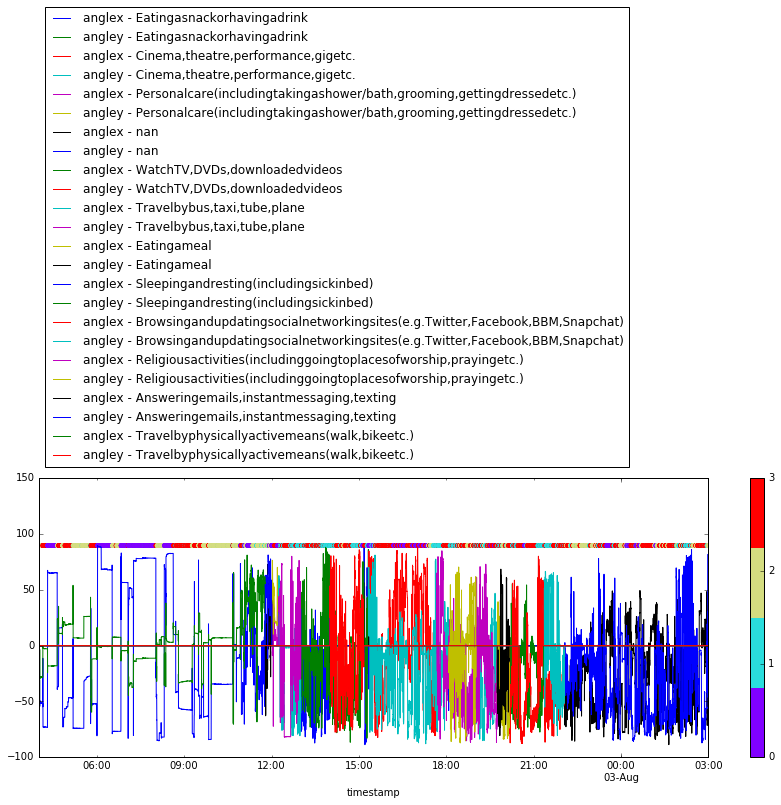

In [24]:
hsmm.plot_states_and_var(data, hidden_states, columns=['anglex', 'angley'], by='Activity')

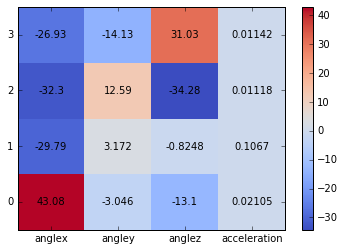

In [25]:
#Plot the means
plotdata = np.array([d.mu for d in model.obs_distns])

hsmm.plot_heatmap(plotdata, horizontal_labels=column_names)

In [26]:
pd.DataFrame(plotdata.transpose(), index=column_names)

0          1          2          3
anglex        43.083521 -29.793077 -32.296189 -26.929855
angley        -3.046075   3.171623  12.588947 -14.125167
anglez       -13.095779  -0.824843 -34.284947  31.026375
acceleration   0.021048   0.106748   0.011180   0.011421

In [27]:
#Plot the mean of the acceleration
#plotdata2 = plotdata[:,3][:,np.newaxis]
#hsmm.plot_heatmap(plotdata2, column_names)

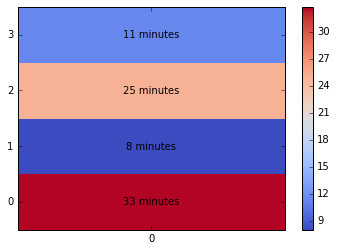

In [28]:
# Plot expected duration
plotdata = np.array([d.lmbda/3. for d in model.dur_distns])[:,np.newaxis]
#grouplabels = ["{:.3} minutes".format(x/3.) for x in plotdata[:,0]]
hsmm.plot_heatmap(plotdata, form='{:.0f} minutes')

Plot the covariance matrix for each state

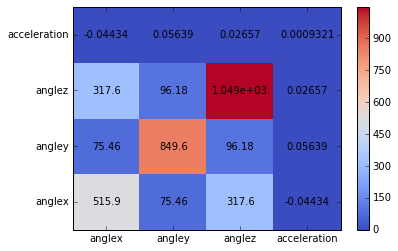

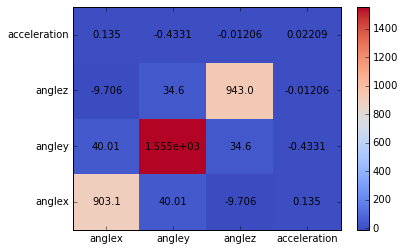

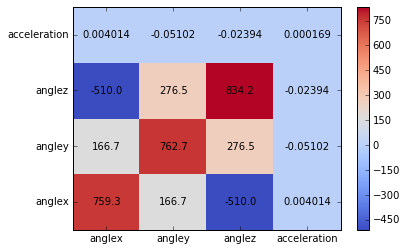

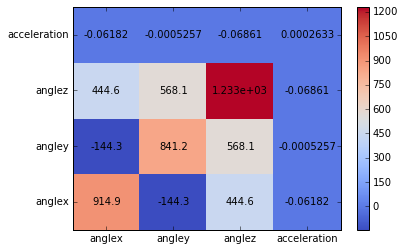

In [29]:
#fig, axs = plt.subplots(nrows=model.num_states, ncols=1,  figsize = (10, 15))
for i in range(model.num_states):
    plotdata = model.obs_distns[i].sigma
    #plt.sca(axs[i])
    hsmm.plot_heatmap(plotdata, horizontal_labels=column_names, vertical_labels=column_names)
#colorbar()
show()

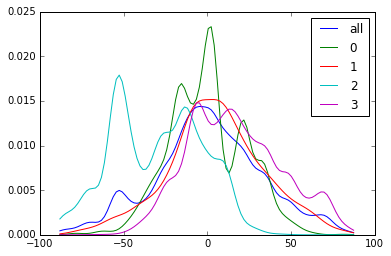

In [30]:
from scipy.stats.kde import gaussian_kde

variable = "anglez"#"acceleration"

fig, ax = subplots()
#day1_5sec.hist(variable, bins=100)
vals = data[variable]
kde = gaussian_kde(vals)
d = np.linspace(min(vals), max(vals), 100)
p = plot(d, kde(d), label="all")

for i in range(model.num_states):
    mask = hidden_states == i
    if(sum(mask)>0 and np.std(vals[mask])>0):
        kde = gaussian_kde(vals[mask])
        plot(d, kde(d), label=str(i))
#ax.set_xlim(0,0.1)
legend()
show()

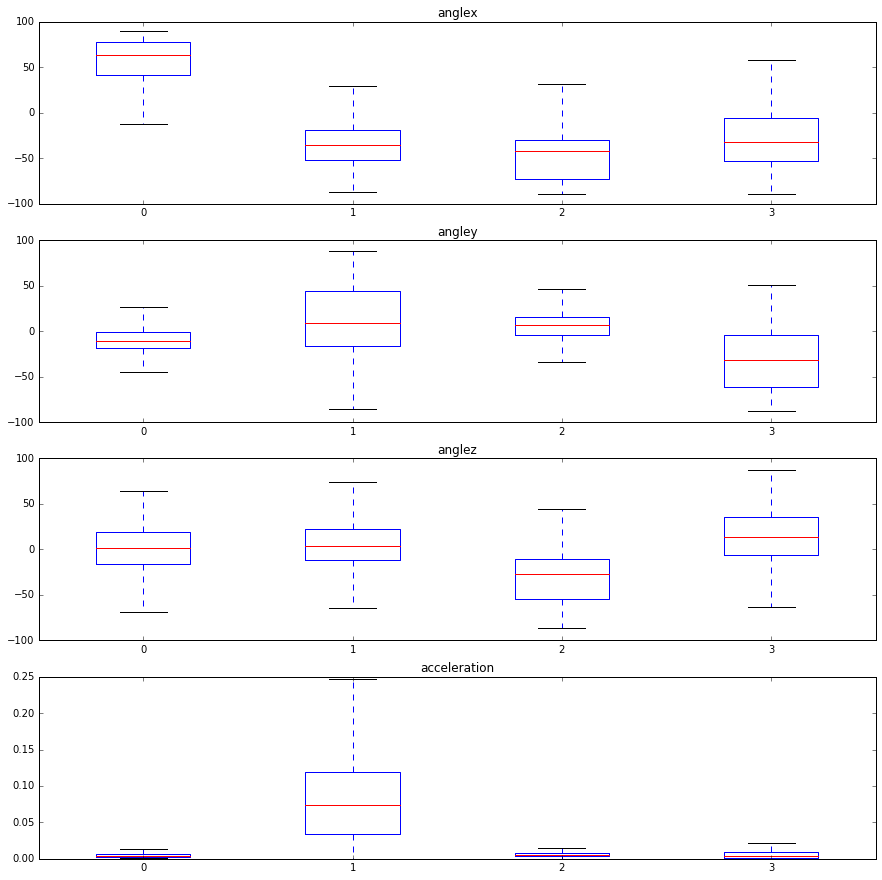

In [31]:
hsmm.plot_boxplots(data[column_names], hidden_states)

In [32]:
def getDurations(hidden_states, nr_states):
    durations = {i: [] for i in range(nr_states)}
    prev = hidden_states[0]
    d = 0
    for x in hidden_states:
        if x == prev:
            d += 1
        else:
            durations[prev].append(d)
            prev = x
            d = 0
    return durations

In [33]:
durations = getDurations(hidden_states, Nmax)
for i, d in durations.iteritems():
    if len(d)>0:
        datdur = np.mean(d)
        distdur = model.dur_distns[i].lmbda
        print('{}\t{:.1f}\t{:.1f}'.format(i, datdur, distdur))
    else:
        print(i)

0	76.2	98.4
1	17.2	24.0
2	64.0	75.0
3	34.9	34.3


In [34]:
all_hidden_states = np.array([s for m in model.stateseqs for s in m])
all_activities = np.array([s for d in datasets for s in list(np.array(d['Activity']))])
print(all_hidden_states.shape)
print(all_activities.shape)

(322900,)
(322900,)


In [35]:
ctab = pd.crosstab(all_activities, all_hidden_states, margins=True).sort_values('All', ascending=False)

In [36]:
ctab

col_0                                                   0      1      2  \
row_0                                                                     
All                                                 70505  75465  90838   
nan                                                 20220  18798  34202   
Sleepingandresting(includingsickinbed)              18614   2514  24757   
Generalinternetbrowsing,programming(nottimeonso...    939   5334   7913   
Speaking,socialisingface-to-face                     5432   4357   4701   
Eatingameal                                           855   4985   2633   
WatchTV,DVDs,downloadedvideos                        2939   3354   3694   
Personalcare(includingtakingashower/bath,groomi...   2671   4912   1714   
PlayingelectronicgamesandApps                        6654   1138   1539   
Travelbyphysicallyactivemeans(walk,bikeetc.)         5060   3160    601   
Travelbycar,van(includingvehiclesownedbyfriends...     87   7088    811   
Answeringemails,instantmessaging,texting             1724   3631   1706   
Didnothing,justrelaxing,bored,waiting                 806   3868   1475   
Otherexerciseandsports,dancing,keepingfit,skiin...      0   3059   1556   
Listeningtomusic,radio,iPod,otheraudiocontent         414   3506    576   
Cinema,theatre,performance,gigetc.                   2379    458    226   
Eatingasnackorhavingadrink                           1259    968     70   
Travelbybus,taxi,tube,plane                           224   1168    276   
Browsingandupdatingsocialnetworkingsites(e.g.Tw...    111    442    765   
Reading(notforschool)                                   0    426    564   
Hobbies,artsandcrafts,musicalactivities,writing...     29    264    437   
Religiousactivities(includinggoingtoplacesofwor...      0    263    512   
Shopping(includingwindowshopping,hangingoutatsh...      0    508     74   
Fixingthingsaroundthehouse,fixingbike,gardening         0    484     31   
Jogging,running,walking,hiking                          0    221      0   
Unpaidworkforfamilyorothernon-householdmembers(...      1    318      5   
Cooking,cleaning,andshoppingforthehousehold             0    207      0   
Petcare                                                87     34      0   

col_0                                                   3     All  
row_0                                                              
All                                                 86092  322900  
nan                                                 31239  104459  
Sleepingandresting(includingsickinbed)              15507   61392  
Generalinternetbrowsing,programming(nottimeonso...   8994   23180  
Speaking,socialisingface-to-face                     3669   18159  
Eatingameal                                          5545   14018  
WatchTV,DVDs,downloadedvideos                        2845   12832  
Personalcare(includingtakingashower/bath,groomi...   2214   11511  
PlayingelectronicgamesandApps                        1406   10737  
Travelbyphysicallyactivemeans(walk,bikeetc.)         1613   10434  
Travelbycar,van(includingvehiclesownedbyfriends...   2333   10319  
Answeringemails,instantmessaging,texting             1849    8910  
Didnothing,justrelaxing,bored,waiting                1649    7798  
Otherexerciseandsports,dancing,keepingfit,skiin...   1025    5640  
Listeningtomusic,radio,iPod,otheraudiocontent         996    5492  
Cinema,theatre,performance,gigetc.                    775    3838  
Eatingasnackorhavingadrink                            542    2839  
Travelbybus,taxi,tube,plane                           893    2561  
Browsingandupdatingsocialnetworkingsites(e.g.Tw...    596    1914  
Reading(notforschool)                                 497    1487  
Hobbies,artsandcrafts,musicalactivities,writing...    552    1282  
Religiousactivities(includinggoingtoplacesofwor...    495    1270  
Shopping(includingwindowshopping,hangingoutatsh...    293     875  
Fixingthingsaroundthehouse,fixingbike,gardening  

In [37]:
ind = list(ctab.index)
pd.crosstab(all_activities, all_hidden_states, normalize='index', margins=True).loc[ind]

col_0                                                      0         1  \
row_0                                                                    
All                                                 0.218349  0.233710   
nan                                                 0.193569  0.179956   
Sleepingandresting(includingsickinbed)              0.303199  0.040950   
Generalinternetbrowsing,programming(nottimeonso...  0.040509  0.230112   
Speaking,socialisingface-to-face                    0.299135  0.239936   
Eatingameal                                         0.060993  0.355614   
WatchTV,DVDs,downloadedvideos                       0.229037  0.261378   
Personalcare(includingtakingashower/bath,groomi...  0.232039  0.426722   
PlayingelectronicgamesandApps                       0.619726  0.105989   
Travelbyphysicallyactivemeans(walk,bikeetc.)        0.484953  0.302856   
Travelbycar,van(includingvehiclesownedbyfriends...  0.008431  0.686888   
Answeringemails,instantmessaging,texting            0.193490  0.407520   
Didnothing,justrelaxing,bored,waiting               0.103360  0.496025   
Otherexerciseandsports,dancing,keepingfit,skiin...  0.000000  0.542376   
Listeningtomusic,radio,iPod,otheraudiocontent       0.075382  0.638383   
Cinema,theatre,performance,gigetc.                  0.619854  0.119333   
Eatingasnackorhavingadrink                          0.443466  0.340965   
Travelbybus,taxi,tube,plane                         0.087466  0.456072   
Browsingandupdatingsocialnetworkingsites(e.g.Tw...  0.057994  0.230930   
Reading(notforschool)                               0.000000  0.286483   
Hobbies,artsandcrafts,musicalactivities,writing...  0.022621  0.205928   
Religiousactivities(includinggoingtoplacesofwor...  0.000000  0.207087   
Shopping(includingwindowshopping,hangingoutatsh...  0.000000  0.580571   
Fixingthingsaroundthehouse,fixingbike,gardening     0.000000  0.621309   
Jogging,running,walking,hiking                      0.000000  0.560914   
Unpaidworkforfamilyorothernon-householdmembers(...  0.002778  0.883333   
Cooking,cleaning,andshoppingforthehousehold         0.000000  0.692308   
Petcare                                             0.719008  0.280992   

col_0                                                      2         3  
row_0                                                                   
All                                                 0.281319  0.266621  
nan                                                 0.327420  0.299055  
Sleepingandresting(includingsickinbed)              0.403261  0.252590  
Generalinternetbrowsing,programming(nottimeonso...  0.341372  0.388007  
Speaking,socialisingface-to-face                    0.258880  0.202049  
Eatingameal                                         0.187830  0.395563  
WatchTV,DVDs,downloadedvideos                       0.287874  0.221711  
Personalcare(includingtakingashower/bath,groomi...  0.148901  0.192338  
PlayingelectronicgamesandApps                       0.143336  0.130949  
Travelbyphysicallyactivemeans(walk,bikeetc.)        0.057600  0.154591  
Travelbycar,van(includingvehiclesownedbyfriends...  0.078593  0.226088  
Answeringemails,instantmessaging,texting            0.191470  0.207520  
Didnothing,justrelaxing,bored,waiting               0.189151  0.211464  
Otherexerciseandsports,dancing,keepingfit,skiin...  0.275887  0.181738  
Listeningtomusic,radio,iPod,otheraudiocontent       0.104880  0.181355  
Cinema,theatre,performance,gigetc.                  0.058885  0.201928  
Eatingasnackorhavingadrink                          0.024657  0.190912  
Travelbybus,taxi,tube,plane                         0.107770  0.348692  
Browsingandupdatingsocialnetworkingsites(e.g.Tw...  0.399687  0.311390  
Reading(notforschool)                               0.379287  0.334230  
Hobbies,artsandcrafts,musicalactivities,writing...  0.340874  0.430577  
Religiousactivities(includinggoingtoplacesofwor...  0.403150  0.389764  
Shopping(includingwindowsho

In [38]:
mask_notnan = np.array(all_activities) != 'nan'
print(mask_notnan.shape)
print()

(322900,)
()


In [39]:
mask_notnan = np.array(all_activities) != 'nan'
all_activities_sub = np.array(all_activities)[mask_notnan]
all_hidden_states_sub = np.array(all_hidden_states)[mask_notnan]
ind = list(ctab.index[2:])
pd.crosstab(all_activities_sub, all_hidden_states_sub, normalize='columns', margins=True).loc[ind]

col_0                                                      0         1  \
row_0                                                                    
Sleepingandresting(includingsickinbed)              0.370170  0.044364   
Generalinternetbrowsing,programming(nottimeonso...  0.018674  0.094129   
Speaking,socialisingface-to-face                    0.108024  0.076888   
Eatingameal                                         0.017003  0.087970   
WatchTV,DVDs,downloadedvideos                       0.058447  0.059188   
Personalcare(includingtakingashower/bath,groomi...  0.053117  0.086682   
PlayingelectronicgamesandApps                       0.132326  0.020082   
Travelbyphysicallyactivemeans(walk,bikeetc.)        0.100626  0.055764   
Travelbycar,van(includingvehiclesownedbyfriends...  0.001730  0.125082   
Answeringemails,instantmessaging,texting            0.034285  0.064076   
Didnothing,justrelaxing,bored,waiting               0.016029  0.068258   
Otherexerciseandsports,dancing,keepingfit,skiin...  0.000000  0.053982   
Listeningtomusic,radio,iPod,otheraudiocontent       0.008233  0.061870   
Cinema,theatre,performance,gigetc.                  0.047310  0.008082   
Eatingasnackorhavingadrink                          0.025037  0.017082   
Travelbybus,taxi,tube,plane                         0.004455  0.020612   
Browsingandupdatingsocialnetworkingsites(e.g.Tw...  0.002207  0.007800   
Reading(notforschool)                               0.000000  0.007518   
Hobbies,artsandcrafts,musicalactivities,writing...  0.000577  0.004659   
Religiousactivities(includinggoingtoplacesofwor...  0.000000  0.004641   
Shopping(includingwindowshopping,hangingoutatsh...  0.000000  0.008965   
Fixingthingsaroundthehouse,fixingbike,gardening     0.000000  0.008541   
Jogging,running,walking,hiking                      0.000000  0.003900   
Unpaidworkforfamilyorothernon-householdmembers(...  0.000020  0.005612   
Cooking,cleaning,andshoppingforthehousehold         0.000000  0.003653   
Petcare                                             0.001730  0.000600   

col_0                                                      2         3  \
row_0                                                                    
Sleepingandresting(includingsickinbed)              0.437125  0.282701   
Generalinternetbrowsing,programming(nottimeonso...  0.139717  0.163966   
Speaking,socialisingface-to-face                    0.083004  0.066888   
Eatingameal                                         0.046490  0.101088   
WatchTV,DVDs,downloadedvideos                       0.065224  0.051866   
Personalcare(includingtakingashower/bath,groomi...  0.030263  0.040362   
PlayingelectronicgamesandApps                       0.027174  0.025632   
Travelbyphysicallyactivemeans(walk,bikeetc.)        0.010612  0.029406   
Travelbycar,van(includingvehiclesownedbyfriends...  0.014320  0.042532   
Answeringemails,instantmessaging,texting            0.030122  0.033708   
Didnothing,justrelaxing,bored,waiting               0.026044  0.030062   
Otherexerciseandsports,dancing,keepingfit,skiin...  0.027474  0.018686   
Listeningtomusic,radio,iPod,otheraudiocontent       0.010170  0.018158   
Cinema,theatre,performance,gigetc.                  0.003990  0.014129   
Eatingasnackorhavingadrink                          0.001236  0.009881   
Travelbybus,taxi,tube,plane                         0.004873  0.016280   
Browsingandupdatingsocialnetworkingsites(e.g.Tw...  0.013507  0.010865   
Reading(notforschool)                               0.009958  0.009061   
Hobbies,artsandcrafts,musicalactivities,writing...  0.007716  0.010063   
Religiousactivities(includinggoingtoplacesofwor...  0.009040  0.009024   
Shopping(includingwindowshopping,hangingoutatsh...  0.001307  0.005342   
Fixingthingsaroundthehouse,fixingbike,gardening     0.000547  0.004813   
Jogging,running,walking,hiking                      0.000000  0.003154   
Unpaidworkforfamilyorothernon-householdmembers(...  0.000088  0.000656   
Coo

In [40]:
all_acceleration = np.array([s for d in datasets for s in list(np.array(d['acceleration']))])
df_as = pd.DataFrame({'acc': all_acceleration, 'state': all_hidden_states})
df_as.groupby('state').mean().transpose()

state         0         1        2         3
acc    0.020445  0.107558  0.01102  0.012003

In [41]:
df_as.groupby('state').std().transpose()

state         0         1         2         3
acc    0.029173  0.148813  0.012199  0.016293

In [42]:
print([d.lmbda*5.0/60 for d in model.dur_distns])

[8.197587437560806, 2.00232419544767, 6.252013507409055, 2.8610823824324667]


In [43]:
len(model.dur_distns)

4

In [44]:
model.trans_distn.full_trans_matrix.tofile(os.path.join(datadir, 'models/model_{}states_transmatrix'.format(Nmax)))